###  Imports

In [5]:
import torch

from model import create_model
from dataset import get_transforms
import config

train_transforms, test_transforms = get_transforms()
torch.manual_seed(1)

In [20]:
item_list = ["car", "dog", "bus", 'fork', 'tie', 'person', 'airplane', 'astronaut', 'space shuttle']

# Check CLIP FRCNN performance

In [21]:
# test out the trained CLIP-FRCNN
MODEL_TYPE = 'CLIP-FRCNN'
CHECKPOINT_NAME = f'{MODEL_TYPE}_epoch_311.pth'

# tokenize item list for CLIP
import clip
_, preprocess = clip.load("RN50", device=config.DEVICE)

if item_list[0] != '':
     item_list.insert(0,' ')

text_tokens = clip.tokenize(["This is " + desc for desc in item_list]).cuda()


clip_frcnn_model = create_model(MODEL_TYPE, classes=text_tokens)
checkpoint = torch.load(CHECKPOINT_NAME)
clip_frcnn_model = create_model(MODEL_TYPE, classes=text_tokens)

clip_frcnn_model.load_state_dict(checkpoint)
clip_frcnn_model.eval()

clip_frcnn_model.rpn.score_thresh = .5

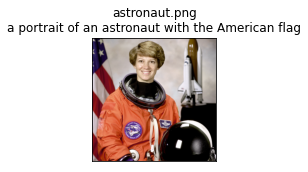

In [8]:
from torchvision.datasets import CIFAR100
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import skimage

original_images = []
images = []
texts = []
plt.figure(figsize=(16, 5))

#texts.append(descriptions["background"])
# images in skimage to use and their textual descriptions
descriptions = {
    # "background": "there is nothing here",
    # "page": "a page of text about segmentation",
    # "chelsea": "a facial photo of a tabby cat",
    "astronaut": "a portrait of an astronaut with the American flag",
    # "rocket": "a rocket standing on a launchpad",
    # "motorcycle_right": "a red motorcycle standing in a garage",
    # "camera": "a person looking at a camera on a tripod",
    # "horse": "a black-and-white silhouette of a horse",
    # "coffee": "a cup of coffee on a saucer"
}
for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    # images.append(preprocess(image))
    images.append(test_transforms(image, [0,0,0,0])[0])
    texts.append(descriptions[name])

#plt.tight_layout()

image_input = torch.tensor(np.stack(images)).cuda()

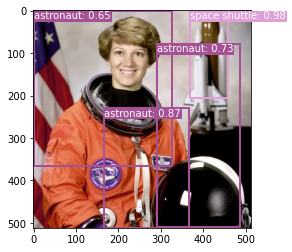

In [26]:
from utils import evaluate
iou_thresh = .2
conf_thresh = .65
image_out = evaluate(image_input, item_list, clip_frcnn_model, iou_thresh, conf_thresh)

In [27]:
plt.imsave('output.jpg',image_out)